# Gradient-Domain Copy Paste

### Developed as a part of the Dartmouth CS70 curriculum

### Author: Jacob Bacus
---

This notebook contains 4 code blocks and their relevant import statements. The code uses least square regression to minimize the pixel intensity change between an background and an image that has been inserted into it. The code finds the best-fit solution to the parameters created by establishing the desired differences between intensities of neighboring pixels. Some things to note:

- The technical code for poisson blending is contained within the `least_squares_2D` function
- The images utilized can be changed within the 2nd code block after the import statements the program should adjust automatically. By default the images used are `background.jpg` and `penguin-chick.jpg`
- Also within the 2nd code block ensure that the last square selected is completely within the bounds of the image or an error will occur

In [1]:
import numpy as np  # for building and manipulating matrices
import time  # for measuring time elapsed while running code

# for sparse matrix operations
from scipy.sparse import lil_matrix
import scipy.sparse.linalg as sla
from scipy.sparse.linalg import lsqr
from skimage.transform import resize

# for graphics
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# for interactive graph features
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'  # nice retina graphics

In [2]:
def least_squares_2D(im_s, im_background):
    #### initialize results to just be copies of the background
    im_blend = im_background.copy()

    #### initialize the size of source image 
    imh, imw = (im_s.shape[0], im_s.shape[1])    #### imh: image height, imw: image width
    imd = 1 if im_s.ndim < 3 else im_s.shape[2]  #### number of components of each pixel, e.g., for an RGB image, imd=3

    width = imw - 2 
    height = imh - 2

    num_vars = height * width
    num_eqns = ((height + 1) * width) + ((width + 1) * height) 

    im2var_inner = np.arange(0, num_vars).reshape(height, width)
    im2var = np.full((imh, imw), -1)
    im2var[1:imh-1, 1:imw-1] = im2var_inner
    

    #### initialize A and b ####
    A = lil_matrix((num_eqns, num_vars))
    b = np.zeros((num_eqns, imd))

    
    index = 0 # determines which equation algorithm is on

    for row in range(1, imh-1):
        for col in range(1, imw-1):
            curPixel = im2var[row, col]

            #### Handle vertical constraints ####
            # Upper boundary vertically
            if row == 1:
                A[index, curPixel] = 1
                b[index] = im_s[row, col] - im_s[row-1, col] + im_background[row-1, col]
            else:
                A[index, curPixel] = 1
                A[index, im2var[row-1, col]] = -1
                b[index] = im_s[row, col] - im_s[row-1, col]
            index += 1

            # Lower boundary vertically 
            if row == imh-2:
                A[index, curPixel] = 1
                b[index] = -im_s[row+1, col] + im_s[row, col] + im_background[row+1, col]
                index += 1

            #### Handle horizontal constraints ####
            # Leftmost boundary 
            if col == 1:
                A[index, curPixel] = 1
                b[index] = im_s[row, col] - im_s[row, col-1] + im_background[row, col-1]
            else:
                A[index, curPixel] = 1
                A[index, im2var[row, col-1]] = -1
                b[index] = im_s[row, col] - im_s[row, col-1]
            index += 1

            # Rightmost boundary
            if col == imw-2:
                A[index, curPixel] = 1
                b[index] = -im_s[row, col+1] + im_s[row, col] + im_background[row, col+1]
                index += 1

    #### solve the least-squares problem ####
    A = A.tocsr()

    print('Solving sparse system using sla.lsqr...')
    t = time.time()

    #### solve for all channels
    for c in range(0, imd):
        
        v = sla.lsqr(A, b[:, c])[0]

        #### copy over to im_blend
        if im_s.ndim > 2: #### this branch is for rgb image
            im_blend[1:-1, 1:-1, c] = v.reshape(height, width)
            
        else: #### this branch is for gray-scale image
            im_blend[1:-1, 1:-1] = v.reshape(height, width)

    elapsed = time.time() - t
    print(f"\tTotal time for sparse solve: {elapsed:.4f} seconds \n")

    #### return the blended result
    return im_blend


## Run the following code and select a region within the graphic shown. A box will generate with your mouse as the bottom right corner. Make sure the entire box is within the image.
---

<IPython.core.display.Javascript object>


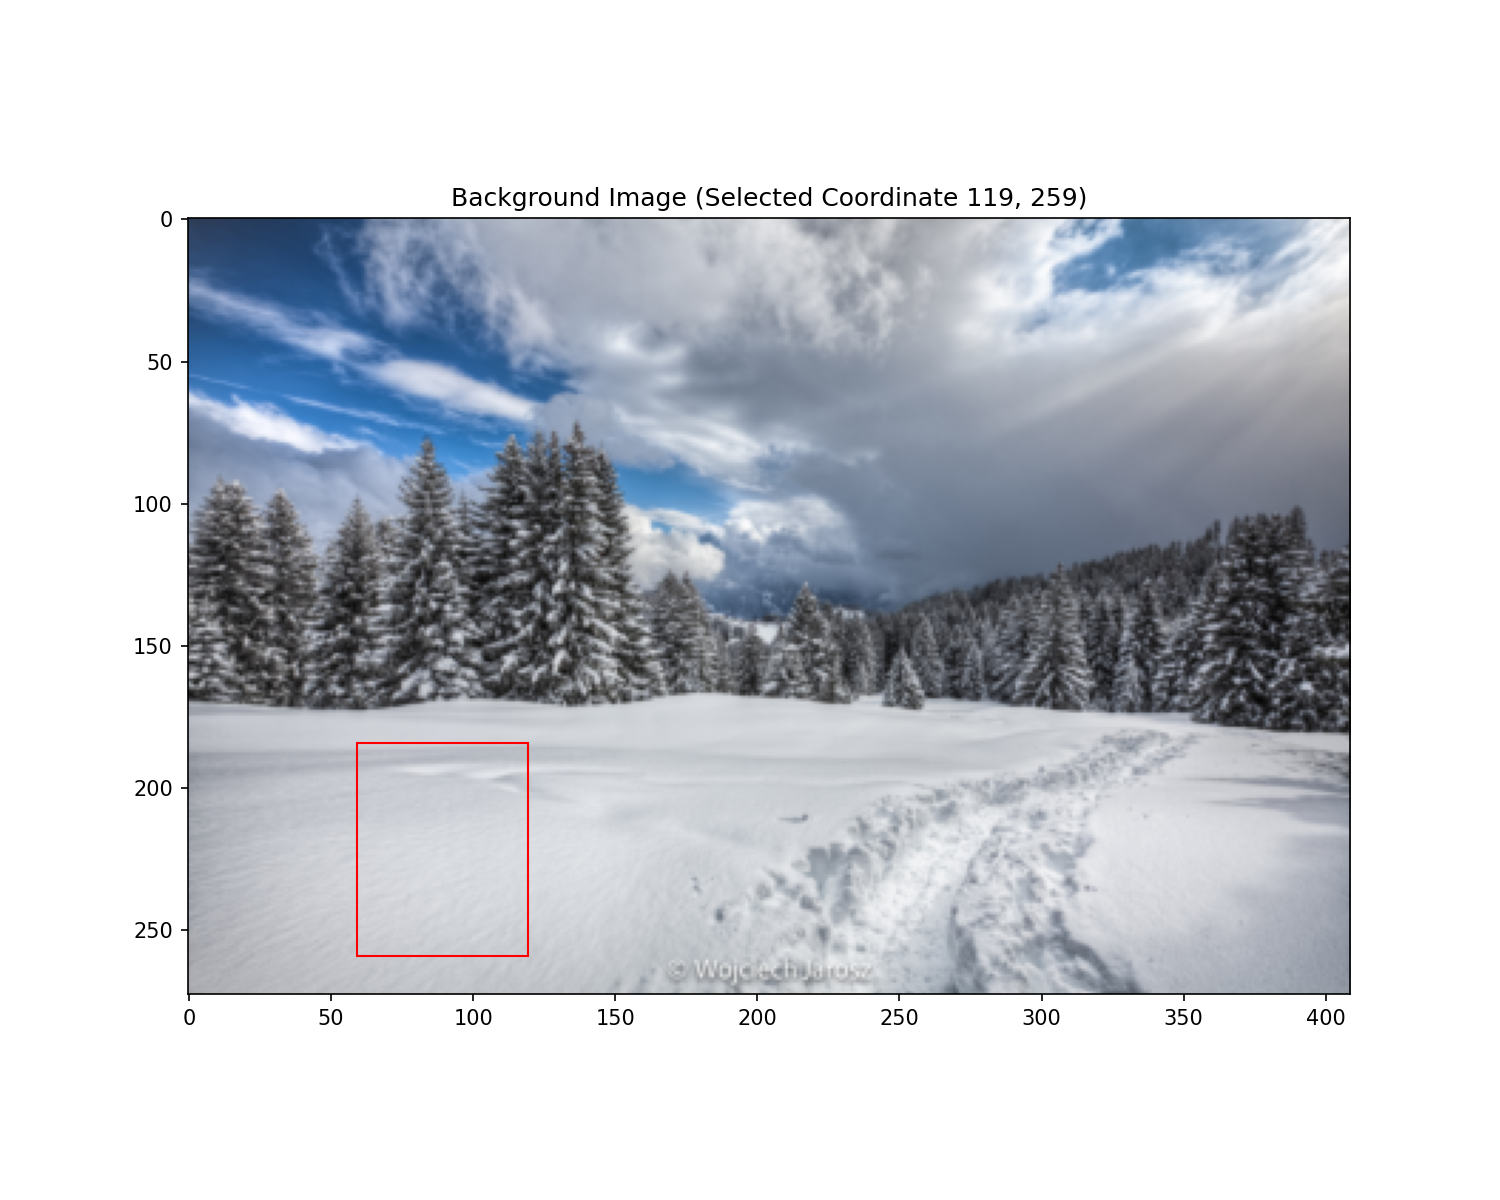

In [3]:
## new gradient domain copy-paste code should go here
# read in background and object images
im_background = plt.imread('images/background.jpg')/255.0
im_object = plt.imread('images/penguin-chick.jpg')/255.0

# reduce the size of the image for faster performance while debugging
# You can comment these two lines out to use the full-resolution images
im_background = resize(im_background, (im_background.shape[0] // 5,
                                       im_background.shape[1] // 5),
                       anti_aliasing=True)
im_object = resize(im_object, (im_object.shape[0] // 5,
                               im_object.shape[1] // 5),
                       anti_aliasing=True)
#
#


# get source region mask from the user
objh, objw, _ = im_object.shape
objmask = np.ones((objh, objw))

# for storing the selected coordinates aligning blending
coords = np.zeros(2, dtype=np.int64)

# handling coordinate selection by storing selected coordinates
def onclick(event):
    global coords, objh, objw
    coords = np.round([event.xdata, event.ydata]).astype(np.int64)
    plt.title(f"Background Image (Selected Coordinate {coords[0]}, {coords[1]})")
    # draw rectangle on image
    rect = Rectangle((event.xdata-objw,event.ydata-objh),objw,objh,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)

# display interactive figure for selecting coordinate in background image
fig = plt.figure()
fig.set_size_inches(10,8)
plt.imshow(im_background)
cid = fig.canvas.mpl_connect('button_press_event', onclick) # for handling button click
plt.title("Background Image (Click a place to blend object image)")
plt.show()

## Run the following two cells to display your image pasted onto the background
---

In [4]:
def simple_copy_paste(coords, im_object, im_background):
    x, y = coords
    objh, objw, _ = im_object.shape
    
    # paste pixel values into im_background
    result = im_background.copy()
    result[y-objh:y, x-objw:x, :] = im_object
    
    return result

def poisson_copy_paste(coords, im_object, im_background):
    x, y = coords
    objh, objw, _ = im_object.shape

    res = im_background.copy()
    background = im_background[y-objh:y, x-objw:x, :]
        
    im_object = least_squares_2D(im_object, background)
    res[y-objh:y, x-objw:x, :] = im_object
        
    return res

<IPython.core.display.Javascript object>


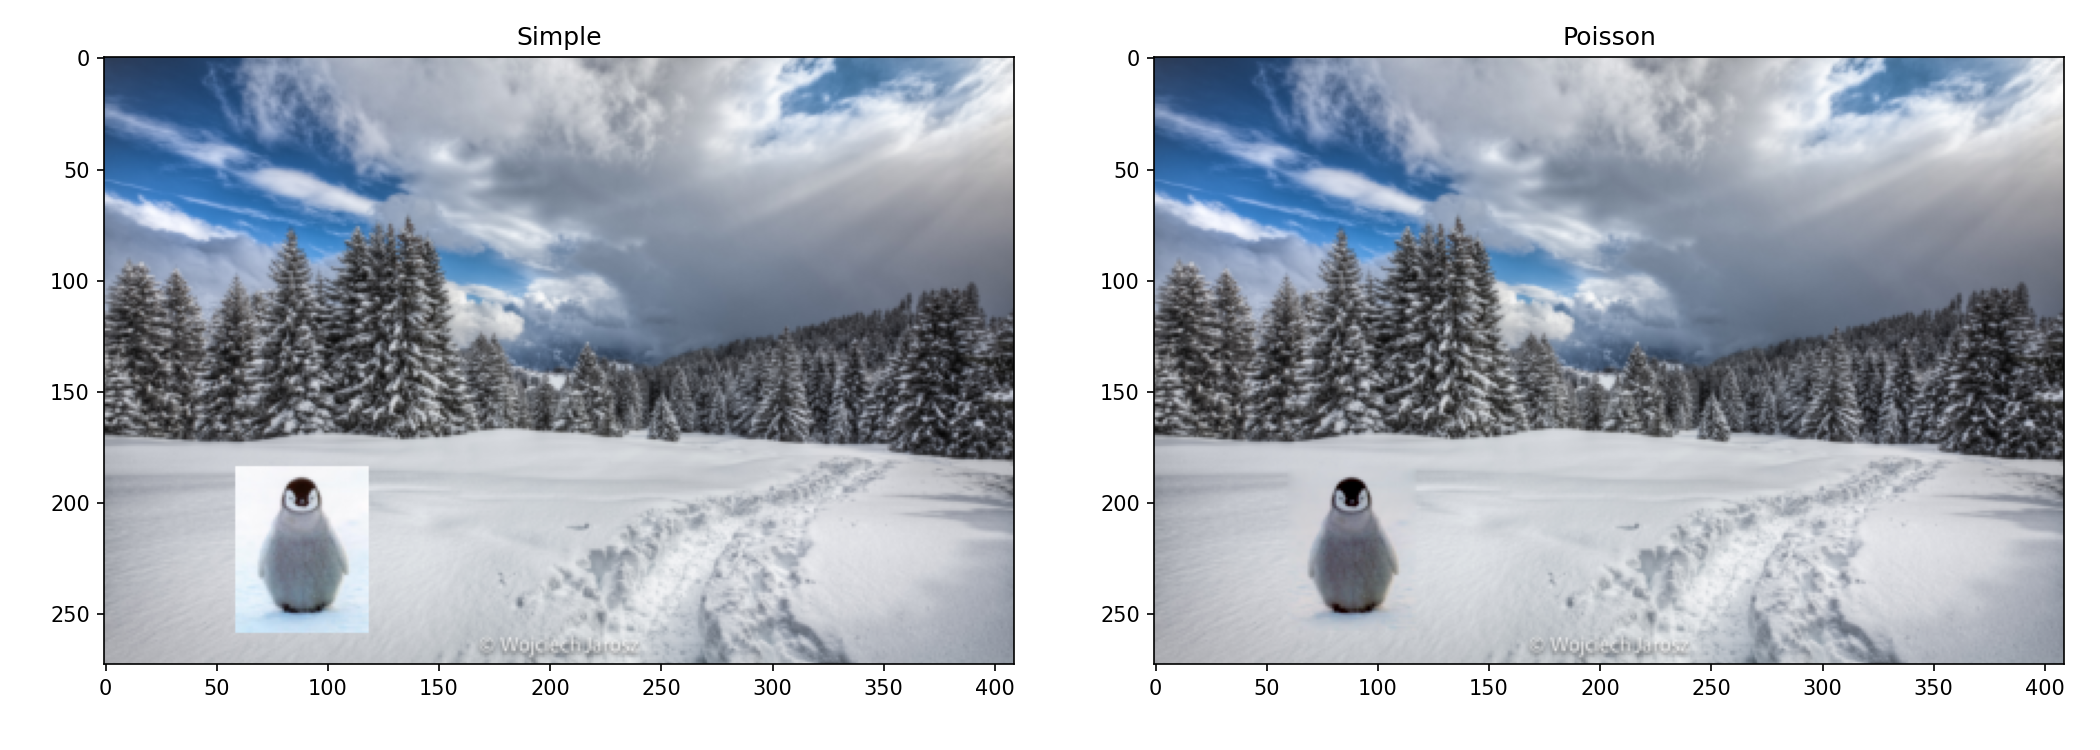

Solving sparse system using sla.lsqr...
	Total time for sparse solve: 0.2297 seconds 



In [5]:
res0 = simple_copy_paste(coords, im_object, im_background)

fig3, axs3 = plt.subplots(1,2)
fig3.tight_layout(pad=0.0)
fig3.set_size_inches(14,5)

# show simple copy-paste first
axs3[0].imshow(res0.clip(0, 1))
axs3[0].set_title("Simple")


res1 = poisson_copy_paste(coords, im_object, im_background)
axs3[1].imshow(res1.clip(0,1))
axs3[1].set_title("Poisson")

plt.show()